# Solve Navier-Stokes equation with fully implicit Crank-Nicolson timestepping

In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis, solvers

Populating the interactive namespace from numpy and matplotlib


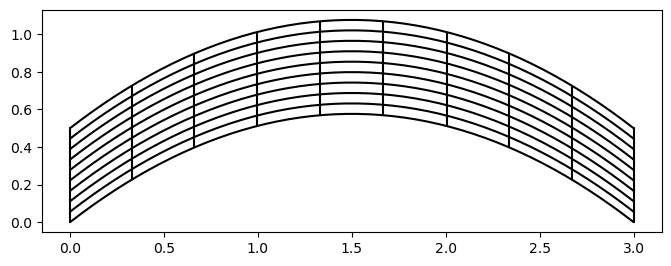

In [2]:
# set up the geometry map
geo = geometry.circular_arc(pi / 8).rotate_2d(pi/2 - pi/16).scale([-1,1])
geo = geo.translate(-geo(0))
geo = geo.scale([3 / geo(1)[0], 30])
geo = geometry.outer_sum(geometry.line_segment([0,0], [0,0.5]), geo)

figsize(8,8)
vis.plot_geo(geo)
axis('scaled');

In [3]:
# define geometry
#geo = geometry.unit_square().scale([3,1])

# define isogeometric discretization space (Taylor-Hood like)
p = 2     # spline degree of velocity space
n_el = (30, 120)   # number of elements in y/x direction

kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=1) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)
n_u1 = prod(m_u)
n_u = 2 * n_u1
n_p = prod(m_p)

In [4]:
def get_components(u):
    """Split solution vector into velocity and pressure components."""
    u1 = u[:n_u1].reshape(m_u)
    u2 = u[n_u1:n_u].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    prs = u[n_u:].reshape(m_p)
    return bspline.BSplineFunc(kvs_u, U), bspline.BSplineFunc(kvs_p, prs)

def vel_norm(u):
    """Return a function for evaluating the norm of the velocity."""
    vel, pre = get_components(u)
    def f(X, Y):
        V = vel.grid_eval((Y,X))
        return norm(V, axis=-1)
    return f

In [5]:
# Dirichlet boundary conditions
def g_inflow(x, y): return (40*y*(0.5-y)*exp(-100*(y-.25)**2), 0.0)
def g_zero(x, y):   return (0.0, 0.0)

bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
    [ ('bottom', g_zero), ('top', g_zero), ('left', g_inflow) ]                                     
)

In [6]:
# Reynolds number
Re = 1e4

# time step
tau = 2e-2

In [7]:
# assemble Stokes problem
A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs_u, bfuns=[('u',2), ('v',2)], geo=geo)
A_div  = assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)
M_pre = assemble.mass(kvs_p, geo)
M_vel = assemble.mass(kvs_u, geo)

M_vel_full = scipy.sparse.bmat(
    [[M_vel, None, None  ],
     [None, M_vel, None  ],
     [None, None, scipy.sparse.csr_matrix((n_p,n_p))]], format='csr')

A_stokes = scipy.sparse.bmat(
    [[Re**-1*A_grad, A_div.T],
     [A_div,     1e-10*M_pre]], format='csr')

In [ ]:
# compute initial value from Stokes equation
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = LS.complete(solvers.make_solver(LS.A).dot(LS.b))
solutions = [LS.restrict(u)]

In [ ]:
# set up nonlinear and linearized N-S system
vel, pre = get_components(u)

#Update does not work currently, so the objects asm_nlconv and asm_linconv are useless

# nonlinear convection term (functional)
#asm_nlconv = assemble.Assembler('grad(vel).dot(vel).dot(v) * dx', kvs_u,
#                    bfuns=[('v',2)], geo=geo, vel=vel, updatable=['vel'])
# linearized convection term by freezing velocity (matrix)
#asm_linconv = assemble.Assembler('grad(u).dot(vel).dot(v) * dx', kvs_u,
#                    bfuns=[('u',2), ('v',2)], geo=geo, vel=vel, updatable=['vel'])

def apply_nl_conv(vel):
    #Update does not work currently:
    # z = asm_nlconv.assemble(vel=vel)
    #Just re-assemble instead:
    z = assemble.assemble('grad(vel).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('v',2)], geo=geo, vel=vel)
    #
    return np.concatenate((z.ravel(), np.zeros(n_p)))

def apply_navier_stokes(u_p):
    vel, pre = get_components(u_p)
    return apply_nl_conv(vel) + A_stokes.dot(u_p)

def linearized_ns(u_p):
    vel, pre = get_components(u_p)
    #Update does not work currently:
    # A_linconv = asm_linconv.assemble(vel=vel)
    #Just re-assemble instead:
    A_linconv = assemble.assemble('grad(u).dot(vel).dot(v) * dx', kvs_u,
                    bfuns=[('u',2), ('v',2)], geo=geo, vel=vel)
    #
    A_lns = scipy.sparse.bmat(
        [[Re**-1*A_grad + A_linconv, A_div.T],
         [A_div,                 1e-10*M_pre]],
        format='csr')
    return A_lns

In [ ]:
# set up DAE for instationary Navier-Stokes
def ns_F(x):
    u_p = LS.complete(x)
    return -LS.restrict(apply_navier_stokes(u_p))
def ns_J(x):
    u_p = LS.complete(x)
    return -LS.restrict_matrix(linearized_ns(u_p))
ns_M = LS.restrict_matrix(M_vel_full)

In [ ]:
t_end = 3.0

time_steps = solvers.rowdaind2(ns_M, ns_F, ns_J, solutions[-1], tau, t_end, tol=1e-2, progress=True)
solutions.extend(time_steps[1][1:])

In [ ]:
# plot history of step sizes
figsize(6,3)
times = array(time_steps[0])
stepsizes = times[1:] - times[:-1]
plot(times[:-1], stepsizes);
xlabel('time'); ylabel('step size');

In [ ]:
T_anim = linspace(0, 3, 200)   # animation timesteps
# interpolate adaptive solution at the animation frame times
sol_interp = scipy.interpolate.interp1d(time_steps[0],
                [LS.complete(uu) for uu in time_steps[1]], axis=0)
fields = [vel_norm(sol_interp(tt)) for tt in T_anim]

In [ ]:
from IPython.display import HTML

figsize(14, 4)
#fields = [vel_norm(LS.complete(uu)) for uu in solutions]
HTML(vis.animate_field(fields, geo, res=(50, 150), vrange=(0,3), interval=35, progress=True).to_html5_video())

In [ ]:
xgrid = linspace(0, 1, 200)
xygrid = (xgrid, xgrid)

velocity, pressure = get_components(LS.complete(solutions[-1]))

In [ ]:
figsize(8,3)
axis('off')
vis.plot_field(pressure, geo);